In [1]:
%pip install pandas seaborn scikit-learn scipy imbalanced-learn
%pip install xlrd openpyxl

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Importing the important libraries and different tools from the modules

In [3]:
# Core libraries
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight

try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    SMOTE = None
    warnings.warn("imblearn not available. Install with `pip install imbalanced-learn` to enable SMOTE demos.")

sns.set_theme(style="whitegrid", palette="deep")
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
ctg_path = Path("ctg.xlsx")
assert ctg_path.exists(), f"Expected Excel file at {ctg_path}"


def read_feature_sheet(path: Path, sheet=0):
    """Load the CTG feature sheet, using row 2 as headers and data from row 3 onward."""
    xls = pd.ExcelFile(path)
    if isinstance(sheet, int):
        sheet_name = xls.sheet_names[sheet]
    else:
        sheet_name = sheet
    try:
        df = pd.read_excel(xls, sheet_name=sheet_name, header=1)
    except ValueError:
        df = pd.read_excel(xls, sheet_name=sheet_name, header=0)
    return df



sheet2_raw = read_feature_sheet(ctg_path, sheet='Data')


print("Sheets detected:", pd.ExcelFile(ctg_path).sheet_names)
print("Feature sheet shape:", sheet2_raw.shape)

Sheets detected: ['Description', 'Data', 'Raw Data']
Feature sheet shape: (2129, 46)


In [5]:
def tidy_sheet(df: pd.DataFrame) -> pd.DataFrame:
    """Drop blank columns/rows, clean names, and deduplicate headers."""
    cleaned = df.copy()  # make a copy so the original DataFrame is untouched
    
    # Ensure all column names are strings and strip whitespace
    cleaned.columns = [str(col).strip() for col in cleaned.columns]
    
    # Drop rows and columns that are completely empty
    cleaned = cleaned.dropna(axis=0, how='all').dropna(axis=1, how='all')
    
    # Remove auto-generated "Unnamed" columns (common from Excel exports)
    cleaned = cleaned.loc[:, ~cleaned.columns.str.contains('^Unnamed', case=False)]
    
    # Drop duplicate column names (keep first occurrence)
    cleaned = cleaned.loc[:, ~cleaned.columns.duplicated()]
    
    # Fix inconsistent or messy column names
    rename_map = {
        'MSTV': 'mSTV',
        'MLTV': 'mLTV',
        'Variance ': 'Variance',
        'TENDENCY': 'Tendency'
    }
    cleaned = cleaned.rename(columns={k: v for k, v in rename_map.items() if k in cleaned.columns})
    
    return cleaned  # return the cleaned DataFrame


# Apply cleaning function to raw sheet
sheet2 = tidy_sheet(sheet2_raw)

# Define target column (the one we want to predict)
target_col = 'NSP'

# List of columns that would "leak" label info if used as features
label_leak_cols = ['CLASS', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP']

# Keep only those leakage columns that actually exist in this sheet
label_leak_cols = [col for col in label_leak_cols if col in sheet2.columns]

# Preview first 5 rows of cleaned data
sheet2.head()


,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,240.00,357.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,120.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1.00,-1.00,9.00,2.00
1,5.00,632.00,4.00,0.00,4.00,2.00,0.00,0.00,0.00,132.00,...,-1.00,-1.00,-1.00,1.00,-1.00,-1.00,-1.00,-1.00,6.00,1.00
2,177.00,779.00,2.00,0.00,5.00,2.00,0.00,0.00,0.00,133.00,...,-1.00,-1.00,-1.00,1.00,-1.00,-1.00,-1.00,-1.00,6.00,1.00
3,411.00,"1,192.00",2.00,0.00,6.00,2.00,0.00,0.00,0.00,134.00,...,-1.00,-1.00,-1.00,1.00,-1.00,-1.00,-1.00,-1.00,6.00,1.00
4,533.00,"1,147.00",4.00,0.00,5.00,0.00,0.00,0.00,0.00,132.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,2.00,1.00


In [6]:
print(sheet2_raw.columns)

Index(['b', 'e', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'DR', 'Unnamed: 9', 'LB',
       'AC.1', 'FM.1', 'UC.1', 'DL.1', 'DS.1', 'DP.1', 'ASTV', 'MSTV', 'ALTV',
       'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
       'Median', 'Variance', 'Tendency', 'Unnamed: 31', 'A', 'B', 'C', 'D',
       'E', 'AD', 'DE', 'LD', 'FS', 'SUSP', 'Unnamed: 42', 'CLASS',
       'Unnamed: 44', 'NSP'],
      dtype='object')


In [7]:
# Drop rows where the target column is NaN
sheet2_cleaned = sheet2.dropna(subset=[target_col])

sheet2 = sheet2_cleaned

print(f"Original shape: {sheet2.shape}")
print(f"Cleaned shape: {sheet2_cleaned.shape}")

# (Optional) check if any NaN remains in target
print("Remaining NaNs in target:", sheet2_cleaned[target_col].isna().sum())


Original shape: (2126, 42)
Cleaned shape: (2126, 42)
Remaining NaNs in target: 0


In [8]:
# Save the shape of the DataFrame (rows, columns)
sheet2_shape = sheet2.shape  

# Print a concise summary of the DataFrame (column names, dtypes, non-nulls, memory usage)
sheet2_info = sheet2.info()  

# Generate descriptive statistics for all columns, transpose it, and show the first 30 rows
# (works for both numeric and categorical features since include='all')
sheet2.describe(include='all').T.head(30)


<class 'pandas.core.frame.DataFrame'>
Index: 2126 entries, 0 to 2125
Data columns (total 42 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   b         2126 non-null   float64
 1   e         2126 non-null   float64
 2   AC        2126 non-null   float64
 3   FM        2126 non-null   float64
 4   UC        2126 non-null   float64
 5   DL        2126 non-null   float64
 6   DS        2126 non-null   float64
 7   DP        2126 non-null   float64
 8   DR        2126 non-null   float64
 9   LB        2126 non-null   float64
 10  AC.1      2126 non-null   float64
 11  FM.1      2126 non-null   float64
 12  UC.1      2126 non-null   float64
 13  DL.1      2126 non-null   float64
 14  DS.1      2126 non-null   float64
 15  DP.1      2126 non-null   float64
 16  ASTV      2126 non-null   float64
 17  mSTV      2126 non-null   float64
 18  ALTV      2126 non-null   float64
 19  mLTV      2126 non-null   float64
 20  Width     2126 non-null   float64
 

,count,mean,std,min,25%,50%,75%,max
b,"2,126.00",878.44,894.08,0.00,55.00,538.00,"1,521.00","3,296.00"
e,"2,126.00","1,702.88",930.92,287.00,"1,009.00","1,241.00","2,434.75","3,599.00"
AC,"2,126.00",2.72,3.56,0.00,0.00,1.00,4.00,26.00
FM,"2,126.00",7.24,37.13,0.00,0.00,0.00,2.00,564.00
UC,"2,126.00",3.66,2.85,0.00,1.00,3.00,5.00,23.00
DL,"2,126.00",1.57,2.50,0.00,0.00,0.00,3.00,16.00
DS,"2,126.00",0.00,0.06,0.00,0.00,0.00,0.00,1.00
DP,"2,126.00",0.13,0.46,0.00,0.00,0.00,0.00,4.00
DR,"2,126.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00
LB,"2,126.00",133.30,9.84,106.00,126.00,133.00,140.00,160.00


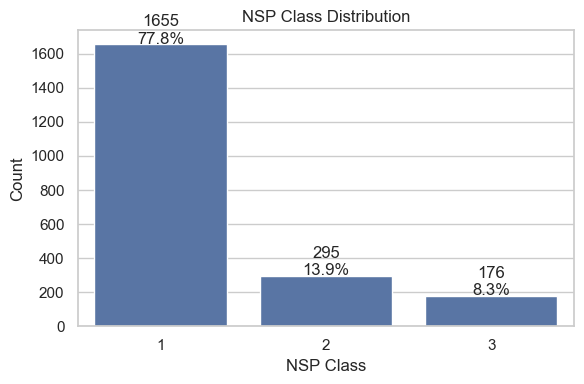

,Class,Count,Proportion
0,1,1655,0.78
1,2,295,0.14
2,3,176,0.08


In [9]:
# Count the occurrences of each target class (NSP) and sort by class index
class_counts = sheet2[target_col].value_counts().sort_index()

# Compute the proportion of each class relative to the total
class_props = class_counts / class_counts.sum()


# --- Visualization ---
fig, ax = plt.subplots(figsize=(6, 4))  # create a figure and axis object
sns.barplot(x=class_counts.index.astype(int), y=class_counts.values, ax=ax)  # barplot of class counts

# Set axis labels and title
ax.set_xlabel('NSP Class')
ax.set_ylabel('Count')
ax.set_title('NSP Class Distribution')

# Add count + proportion labels above each bar
for index, value in enumerate(class_counts.values):
    label = f"{value}\n{class_props.iloc[index]:.1%}"  # show both absolute count and %
    ax.text(index, value + 5, label, ha='center')

# Make layout tight so labels don’t overlap
plt.tight_layout()
plt.show()


# --- Tabular summary ---
# Create a DataFrame showing class ID, raw counts, and proportions
pd.DataFrame({
    'Class': class_counts.index.astype(int),
    'Count': class_counts.values,
    'Proportion': class_props.values
})


In [10]:
feature_groups = {
    'physiological': ['AC', 'FM', 'UC', 'DL', 'DS', 'DP'],
    'variability': ['ASTV', 'mSTV', 'ALTV', 'mLTV'],
    'histogram': ['Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance', 'Tendency'],
    'timing': ['b', 'e'],
    'baseline': ['LBE', 'LB']
}

available_features = {group: [col for col in cols if col in sheet2.columns]
                      for group, cols in feature_groups.items()}
available_features

{'physiological': ['AC', 'FM', 'UC', 'DL', 'DS', 'DP'],
 'variability': ['ASTV', 'mSTV', 'ALTV', 'mLTV'],
 'histogram': ['Width',
  'Min',
  'Max',
  'Nmax',
  'Nzeros',
  'Mode',
  'Mean',
  'Median',
  'Variance',
  'Tendency'],
 'timing': ['b', 'e'],
 'baseline': ['LB']}

In [11]:


# Define the physiological feature columns explicitly
physio_features = feature_groups['physiological']


# Check NaN counts per column
nan_counts = sheet2[physio_features].isna().sum()

print("NaN counts in physiological features:")
print(nan_counts)

# Optional: show rows that contain any NaN in these features
nan_rows = sheet2[sheet2[physio_features].isna().any(axis=1)]
print("\nRows with missing values in physiological features:")
print(nan_rows.head())



NaN counts in physiological features:
AC    0
FM    0
UC    0
DL    0
DS    0
DP    0
dtype: int64

Rows with missing values in physiological features:
Empty DataFrame
Columns: [b, e, AC, FM, UC, DL, DS, DP, DR, LB, AC.1, FM.1, UC.1, DL.1, DS.1, DP.1, ASTV, mSTV, ALTV, mLTV, Width, Min, Max, Nmax, Nzeros, Mode, Mean, Median, Variance, Tendency, A, B, C, D, E, AD, DE, LD, FS, SUSP, CLASS, NSP]
Index: []

[0 rows x 42 columns]


In [12]:
# Define the physiological feature columns
physio_features = feature_groups['physiological']

# Drop rows with NaN in any of the physiological features
sheet2_cleaned = sheet2.dropna(subset=physio_features)

print(f"Original shape: {sheet2.shape}")
print(f"Cleaned shape: {sheet2_cleaned.shape}")

sheet2_cleaned.describe()

Original shape: (2126, 42)
Cleaned shape: (2126, 42)


,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
count,"2,126.00","2,126.00","2,126.00","2,126.00","2,126.00","2,126.00","2,126.00","2,126.00","2,126.00","2,126.00",...,"2,126.00","2,126.00","2,126.00","2,126.00","2,126.00","2,126.00","2,126.00","2,126.00","2,126.00","2,126.00"
mean,878.44,"1,702.88",2.72,7.24,3.66,1.57,0.00,0.13,0.00,133.30,...,-0.95,-0.92,-0.93,-0.69,-0.76,-0.90,-0.94,-0.81,4.51,1.30
std,894.08,930.92,3.56,37.13,2.85,2.50,0.06,0.46,0.00,9.84,...,0.31,0.38,0.36,0.73,0.65,0.44,0.35,0.58,3.03,0.61
min,0.00,287.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,106.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1.00,1.00
25%,55.00,"1,009.00",0.00,0.00,1.00,0.00,0.00,0.00,0.00,126.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,2.00,1.00
50%,538.00,"1,241.00",1.00,0.00,3.00,0.00,0.00,0.00,0.00,133.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,4.00,1.00
75%,"1,521.00","2,434.75",4.00,2.00,5.00,3.00,0.00,0.00,0.00,140.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,7.00,1.00
max,"3,296.00","3,599.00",26.00,564.00,23.00,16.00,1.00,4.00,0.00,160.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,10.00,3.00


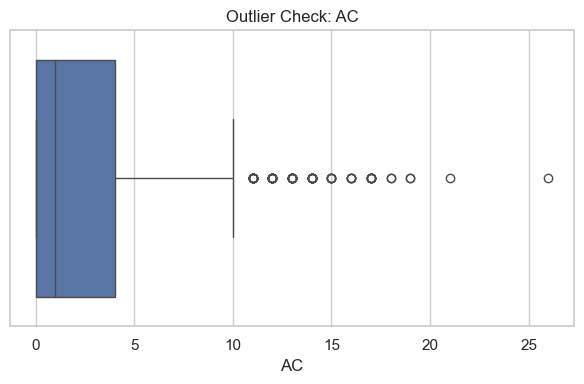

,AC,NSP
427,15.00,1.00
496,17.00,1.00
500,17.00,1.00
526,18.00,1.00
629,16.00,1.00
630,14.00,1.00
673,14.00,1.00
1031,14.00,1.00
1093,14.00,1.00
1623,19.00,1.00


In [13]:
# Pick a feature to check for outliers (prefer 'DP', else fallback to first physiological feature)
outlier_feature = 'AC'

# --- Boxplot visualization ---
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(x=sheet2[outlier_feature], ax=ax)  # plot distribution with whiskers/outliers
ax.set_title(f'Outlier Check: {outlier_feature}')
plt.tight_layout()
plt.show()

# --- Z-score method for outlier detection ---
# Compute z-scores for the feature (ignoring NaNs)
dp_scores = stats.zscore(sheet2[outlier_feature].dropna())

# Mark as outlier if |z-score| > 3
outlier_mask = np.abs(dp_scores) > 3

# Get the indices of rows that are outliers
outlier_indices = sheet2[outlier_feature].dropna().index[outlier_mask]

# Show the feature value and target class for flagged outlier rows
sheet2.loc[outlier_indices, [outlier_feature, target_col]]


In [46]:
# Example list of row indices
rows_to_show = [1647]

# Print the corresponding rows
print(sheet2.loc[rows_to_show])


          b        e    AC   FM    UC    DL   DS   DP   DR     LB  ...     C  \
1647 357.00 3,591.00 26.00 3.00 13.00 12.00 0.00 0.00 0.00 130.00  ... -1.00   

         D     E   AD    DE    LD    FS  SUSP  CLASS  NSP  
1647 -1.00 -1.00 1.00 -1.00 -1.00 -1.00 -1.00   6.00 1.00  

[1 rows x 42 columns]


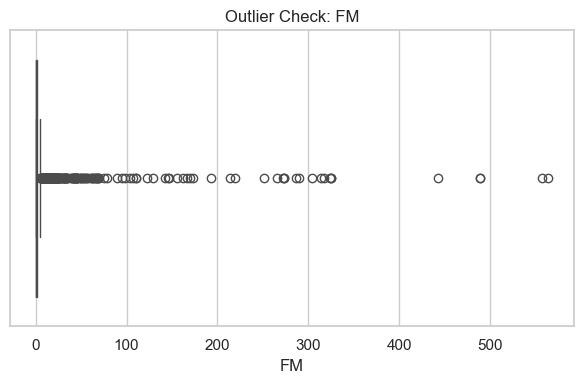

,FM,NSP
13,147.00,1.00
14,489.00,1.00
15,273.00,1.00
16,290.00,1.00
17,251.00,2.00
18,317.00,1.00
19,557.00,1.00
20,304.00,3.00
21,272.00,1.00
22,219.00,3.00


In [14]:
# Pick a feature to check for outliers (prefer 'DP', else fallback to first physiological feature)
outlier_feature = 'FM'

# --- Boxplot visualization ---
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(x=sheet2[outlier_feature], ax=ax)  # plot distribution with whiskers/outliers
ax.set_title(f'Outlier Check: {outlier_feature}')
plt.tight_layout()
plt.show()

# --- Z-score method for outlier detection ---
# Compute z-scores for the feature (ignoring NaNs)
dp_scores = stats.zscore(sheet2[outlier_feature].dropna())

# Mark as outlier if |z-score| > 3
outlier_mask = np.abs(dp_scores) > 3

# Get the indices of rows that are outliers
outlier_indices = sheet2[outlier_feature].dropna().index[outlier_mask]

# Show the feature value and target class for flagged outlier rows
sheet2.loc[outlier_indices, [outlier_feature, target_col]]


In [48]:
# Example list of row indices
rows_to_show = [19, 693]

# Print the corresponding rows
print(sheet2.loc[rows_to_show])


       b        e   AC     FM   UC   DL   DS   DP   DR     LB  ...     C  \
19  7.00 1,194.00 6.00 557.00 6.00 5.00 0.00 1.00 0.00 130.00  ... -1.00   
693 0.00 1,199.00 5.00 564.00 6.00 4.00 0.00 1.00 0.00 133.00  ... -1.00   

        D     E   AD    DE    LD    FS  SUSP  CLASS  NSP  
19  -1.00 -1.00 1.00 -1.00 -1.00 -1.00 -1.00   6.00 1.00  
693 -1.00 -1.00 1.00 -1.00 -1.00 -1.00 -1.00   6.00 1.00  

[2 rows x 42 columns]


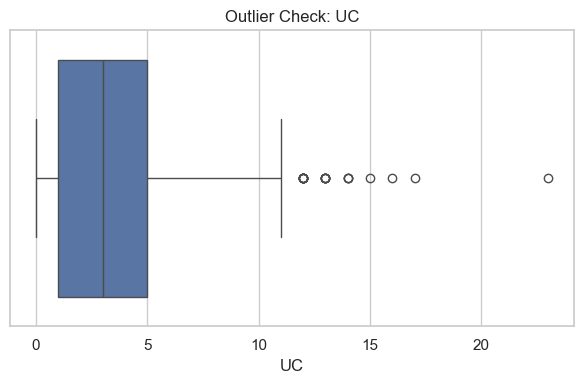

,UC,NSP
792,17.00,1.00
793,13.00,1.00
1290,13.00,1.00
1631,14.00,1.00
1632,15.00,1.00
1647,13.00,1.00
1679,14.00,1.00
1680,16.00,1.00
1956,13.00,3.00
1957,13.00,3.00


In [16]:
# Pick a feature to check for outliers (prefer 'DP', else fallback to first physiological feature)
outlier_feature = 'UC'

# --- Boxplot visualization ---
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(x=sheet2[outlier_feature], ax=ax)  # plot distribution with whiskers/outliers
ax.set_title(f'Outlier Check: {outlier_feature}')
plt.tight_layout()
plt.show()

# --- Z-score method for outlier detection ---
# Compute z-scores for the feature (ignoring NaNs)
dp_scores = stats.zscore(sheet2[outlier_feature].dropna())

# Mark as outlier if |z-score| > 3
outlier_mask = np.abs(dp_scores) > 3

# Get the indices of rows that are outliers
outlier_indices = sheet2[outlier_feature].dropna().index[outlier_mask]

# Show the feature value and target class for flagged outlier rows
sheet2.loc[outlier_indices, [outlier_feature, target_col]]


In [44]:
# Example list of row indices
rows_to_show = [2086]

# Print the corresponding rows
print(sheet2.loc[rows_to_show])


        b        e   AC    FM    UC   DL   DS   DP   DR     LB  ...     C  \
2086 0.00 3,599.00 0.00 10.00 23.00 0.00 0.00 0.00 0.00 133.00  ... -1.00   

         D     E    AD    DE    LD    FS  SUSP  CLASS  NSP  
2086 -1.00 -1.00 -1.00 -1.00 -1.00 -1.00 -1.00   1.00 2.00  

[1 rows x 42 columns]


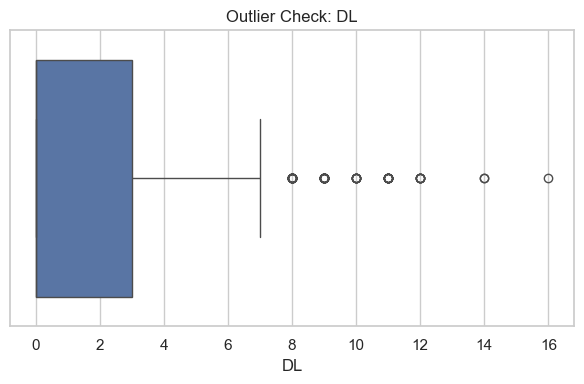

,DL,NSP
28,10.00,2.00
30,12.00,1.00
31,10.00,1.00
743,11.00,1.00
1152,11.00,1.00
1153,11.00,1.00
1615,12.00,1.00
1647,12.00,1.00
1648,14.00,1.00
1649,11.00,1.00


In [17]:
# Pick a feature to check for outliers (prefer 'DP', else fallback to first physiological feature)
outlier_feature = 'DL'

# --- Boxplot visualization ---
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(x=sheet2[outlier_feature], ax=ax)  # plot distribution with whiskers/outliers
ax.set_title(f'Outlier Check: {outlier_feature}')
plt.tight_layout()
plt.show()

# --- Z-score method for outlier detection ---
# Compute z-scores for the feature (ignoring NaNs)
dp_scores = stats.zscore(sheet2[outlier_feature].dropna())

# Mark as outlier if |z-score| > 3
outlier_mask = np.abs(dp_scores) > 3

# Get the indices of rows that are outliers
outlier_indices = sheet2[outlier_feature].dropna().index[outlier_mask]

# Show the feature value and target class for flagged outlier rows
sheet2.loc[outlier_indices, [outlier_feature, target_col]]


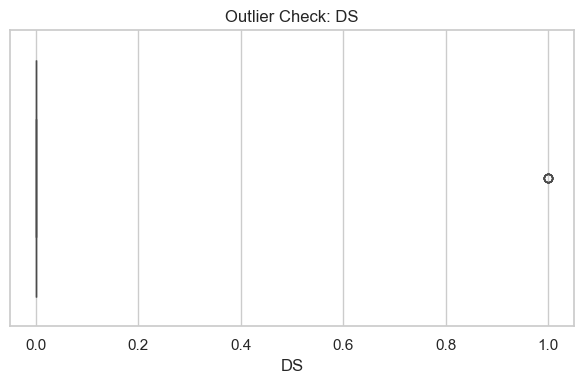

,DS,NSP
1488,1.00,1.00
1489,1.00,3.00
1791,1.00,3.00
1792,1.00,3.00
1793,1.00,3.00
1794,1.00,3.00
1795,1.00,3.00


In [18]:
# Pick a feature to check for outliers (prefer 'DP', else fallback to first physiological feature)
outlier_feature = 'DS'

# --- Boxplot visualization ---
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(x=sheet2[outlier_feature], ax=ax)  # plot distribution with whiskers/outliers
ax.set_title(f'Outlier Check: {outlier_feature}')
plt.tight_layout()
plt.show()

# --- Z-score method for outlier detection ---
# Compute z-scores for the feature (ignoring NaNs)
dp_scores = stats.zscore(sheet2[outlier_feature].dropna())

# Mark as outlier if |z-score| > 3
outlier_mask = np.abs(dp_scores) > 3

# Get the indices of rows that are outliers
outlier_indices = sheet2[outlier_feature].dropna().index[outlier_mask]

# Show the feature value and target class for flagged outlier rows
sheet2.loc[outlier_indices, [outlier_feature, target_col]]


In [19]:
# Example list of row indices
rows_to_show = [1488]

# Print the corresponding rows
print(sheet2.loc[rows_to_show])


            b        e   AC   FM   UC   DL   DS   DP   DR     LB  ...     C  \
1488 1,532.00 2,655.00 2.00 0.00 9.00 0.00 1.00 1.00 0.00 132.00  ... -1.00   

         D     E   AD    DE    LD    FS  SUSP  CLASS  NSP  
1488 -1.00 -1.00 1.00 -1.00 -1.00 -1.00 -1.00   6.00 1.00  

[1 rows x 42 columns]


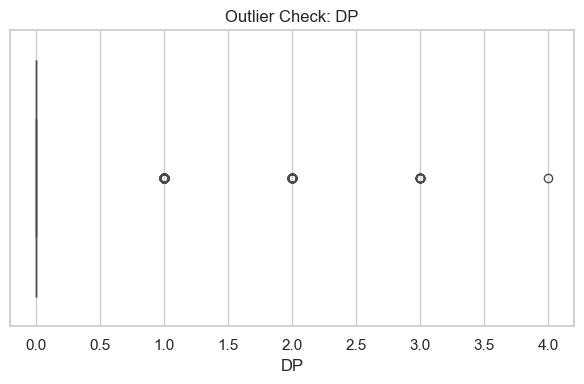

,DP,NSP
20,3.00,3.00
700,3.00,3.00
1345,3.00,2.00
1346,3.00,3.00
1347,3.00,3.00
1752,3.00,3.00
1753,3.00,3.00
1754,3.00,3.00
1755,3.00,3.00
1756,3.00,3.00


In [42]:
# Pick a feature to check for outliers (prefer 'DP', else fallback to first physiological feature)
outlier_feature = 'DP'

# --- Boxplot visualization ---
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(x=sheet2[outlier_feature], ax=ax)  # plot distribution with whiskers/outliers
ax.set_title(f'Outlier Check: {outlier_feature}')
plt.tight_layout()
plt.show()

# --- Z-score method for outlier detection ---
# Compute z-scores for the feature (ignoring NaNs)
dp_scores = stats.zscore(sheet2[outlier_feature].dropna())

# Mark as outlier if |z-score| > 3
outlier_mask = np.abs(dp_scores) > 5

# Get the indices of rows that are outliers
outlier_indices = sheet2[outlier_feature].dropna().index[outlier_mask]

# Show the feature value and target class for flagged outlier rows
sheet2.loc[outlier_indices, [outlier_feature, target_col]]


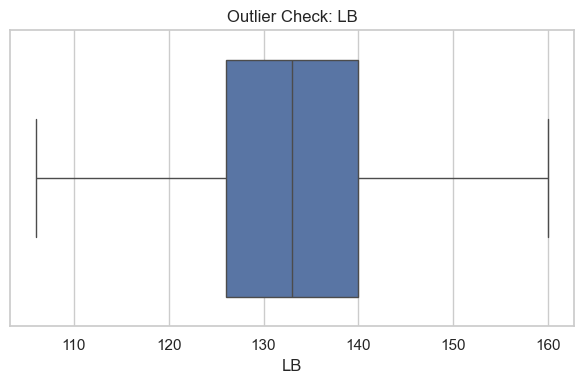

,LB,NSP
125,159.00,2.00
126,159.00,2.00
127,159.00,2.00
128,159.00,2.00
133,159.00,1.00
134,159.00,1.00
135,159.00,2.00
136,159.00,1.00
137,159.00,2.00
138,159.00,2.00


In [58]:
# Pick a feature to check for outliers (prefer 'DP', else fallback to first physiological feature)
outlier_feature = 'LB'

# --- Boxplot visualization ---
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(x=sheet2[outlier_feature], ax=ax)  # plot distribution with whiskers/outliers
ax.set_title(f'Outlier Check: {outlier_feature}')
plt.tight_layout()
plt.show()

# --- Z-score method for outlier detection ---
# Compute z-scores for the feature (ignoring NaNs)
dp_scores = stats.zscore(sheet2[outlier_feature].dropna())

# Mark as outlier if |z-score| > 3
outlier_mask = np.abs(dp_scores) > 2.6

# Get the indices of rows that are outliers
outlier_indices = sheet2[outlier_feature].dropna().index[outlier_mask]

# Show the feature value and target class for flagged outlier rows
sheet2.loc[outlier_indices, [outlier_feature, target_col]]


In [70]:
# Choose which columns to drop (these are known label leakage columns)
columns_to_drop = label_leak_cols  

# Print which columns are being dropped (helps with debugging/verification)
print('Dropping label leakage columns:', columns_to_drop)

# Drop the leakage columns from the dataset
# errors='ignore' ensures no error is raised if some columns are missing
clean_df = sheet2.drop(columns=columns_to_drop, errors='ignore')

# Preview the first 5 rows of the cleaned DataFrame
clean_df.head()
clean_df.shape
clean_df.columns
clean_df.describe()


Dropping label leakage columns: ['CLASS', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP']


,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
count,"2,126.00","2,126.00","2,126.00","2,126.00","2,126.00","2,126.00","2,126.00","2,126.00","2,126.00","2,126.00",...,"2,126.00","2,126.00","2,126.00","2,126.00","2,126.00","2,126.00","2,126.00","2,126.00","2,126.00","2,126.00"
mean,878.44,"1,702.88",2.72,7.24,3.66,1.57,0.00,0.13,0.00,133.30,...,93.58,164.03,4.07,0.32,137.45,134.61,138.09,18.81,0.32,1.30
std,894.08,930.92,3.56,37.13,2.85,2.50,0.06,0.46,0.00,9.84,...,29.56,17.94,2.95,0.71,16.38,15.59,14.47,28.98,0.61,0.61
min,0.00,287.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,106.00,...,50.00,122.00,0.00,0.00,60.00,73.00,77.00,0.00,-1.00,1.00
25%,55.00,"1,009.00",0.00,0.00,1.00,0.00,0.00,0.00,0.00,126.00,...,67.00,152.00,2.00,0.00,129.00,125.00,129.00,2.00,0.00,1.00
50%,538.00,"1,241.00",1.00,0.00,3.00,0.00,0.00,0.00,0.00,133.00,...,93.00,162.00,3.00,0.00,139.00,136.00,139.00,7.00,0.00,1.00
75%,"1,521.00","2,434.75",4.00,2.00,5.00,3.00,0.00,0.00,0.00,140.00,...,120.00,174.00,6.00,0.00,148.00,145.00,148.00,24.00,1.00,1.00
max,"3,296.00","3,599.00",26.00,564.00,23.00,16.00,1.00,4.00,0.00,160.00,...,159.00,238.00,18.00,10.00,187.00,182.00,186.00,269.00,1.00,3.00


In [68]:
# Check if both LB (baseline FHR) and ASTV (short-term variability) columns exist
if {'LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP'}.issubset(clean_df.columns):

    # --- Categorize Baseline Heart Rate (LB) into clinical ranges ---
    baseline_bins = pd.cut(
        clean_df['LB'],
        bins=[0, 110, 160, np.inf],  # thresholds: <110, 110–160, >160
        labels=['Bradycardic', 'Normal baseline', 'Tachycardic']
    )

    # --- Categorize ASTV (percentage of abnormal short-term variability) ---
    variability_alert = pd.cut(
        clean_df['AC'],
        bins=[0, 10, 25, np.inf],  # thresholds: <10, 10–25, >25
        labels=['<10% (worrisome)', '10-25% (borderline)', '>25% (reassuring)']
    )

    # --- Cross-tabulate categories with target column (NSP) ---
    baseline_ct = pd.crosstab(baseline_bins, clean_df[target_col])
    variability_ct = pd.crosstab(variability_alert, clean_df[target_col])

    # Display contingency tables for interpretation
    display(baseline_ct)
    display(variability_ct)

else:
    # If required columns are missing, print a warning
    print('Baseline or ASTV columns missing from clean_df.')


NSP,1.00,2.00,3.00
LB,,,
Bradycardic,22,0,6
Normal baseline,1633,295,170


NSP,1.00,2.00,3.00
ASTV,,,
10-25% (borderline),294,5,2
>25% (reassuring),1361,290,174


In [72]:
if {'LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP'}.issubset(clean_df.columns):

    bin_specs = {
        'LB': {
            'bins': [0, 110, 160, np.inf],
            'labels': ['Bradycardic (<110)', 'Normal (110-160)', 'Tachycardic (>160)']
        },
        'AC': {
            'bins': [-0.1, 0, 4, 10, np.inf],
            'labels': ['None (0)', 'Low (1-4)', 'Normal (5-10)', 'High (>10)']
        },
        'FM': {
            'bins': [-0.1, 0, 20, 100, np.inf],
            'labels': ['None (0)', 'Few (1-20)', 'Moderate (21-100)', 'Excessive (>100)']
        },
        'UC': {
            'bins': [-0.1, 0, 5, 10, np.inf],
            'labels': ['None (0)', 'Normal (1-5)', 'Frequent (6-10)', 'Excessive (>10)']
        },
        'DL': {
            'bins': [-0.1, 0, 3, 10, np.inf],
            'labels': ['None (0)', 'Few (1-3)', 'Frequent (4-10)', 'Severe (>10)']
        },
        'DS': {
            'bins': [-0.1, 0, np.inf],
            'labels': ['None (0)', 'Present (≥1)']
        },
        'DP': {
            'bins': [-0.1, 0, 1, np.inf],
            'labels': ['None (0)', 'Mild (1)', 'Severe (≥2)']
        }
    }

    # Apply binning and display cross-tabs
    for feature, spec in bin_specs.items():
        categorized = pd.cut(clean_df[feature], bins=spec['bins'], labels=spec['labels'])
        ct = pd.crosstab(categorized, clean_df[target_col])
        print(f"\nCross-tab for {feature}:")
        display(ct)

else:
    print("Some physiological columns are missing from clean_df.")



Cross-tab for LB:


NSP,1.00,2.00,3.00
LB,,,
Bradycardic (<110),22,0,6
Normal (110-160),1633,295,170



Cross-tab for AC:


NSP,1.00,2.00,3.00
AC,,,
None (0),496,249,146
Low (1-4),642,44,30
Normal (5-10),434,2,0
High (>10),83,0,0



Cross-tab for FM:


NSP,1.00,2.00,3.00
FM,,,
None (0),1071,158,82
Few (1-20),494,129,82
Moderate (21-100),70,4,1
Excessive (>100),20,4,11



Cross-tab for UC:


NSP,1.00,2.00,3.00
UC,,,
None (0),155,121,56
Normal (1-5),1059,139,77
Frequent (6-10),412,33,36
Excessive (>10),29,2,7



Cross-tab for DL:


NSP,1.00,2.00,3.00
DL,,,
None (0),922,238,71
Few (1-3),387,46,38
Frequent (4-10),333,11,59
Severe (>10),13,0,8



Cross-tab for DS:


NSP,1.00,2.00,3.00
DS,,,
None (0),1654,295,170
Present (≥1),1,0,6



Cross-tab for DP:


NSP,1.00,2.00,3.00
DP,,,
None (0),1586,280,82
Mild (1),69,12,28
Severe (≥2),0,3,66


In [74]:
if {'LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP'}.issubset(clean_df.columns):

    bin_specs = {
        'LB': {
            'bins': [0, 110, 160, np.inf],
            'labels': ['Bradycardic (<110)', 'Normal (110-160)', 'Tachycardic (>160)']
        },
        'AC': {
            'bins': [-0.1, 0, 4, 10, np.inf],
            'labels': ['None (0)', 'Low (1-4)', 'Normal (5-10)', 'High (>10)']
        },
        'FM': {
            'bins': [-0.1, 0, 20, 100, np.inf],
            'labels': ['None (0)', 'Few (1-20)', 'Moderate (21-100)', 'Excessive (>100)']
        },
        'UC': {
            'bins': [-0.1, 0, 5, 10, np.inf],
            'labels': ['None (0)', 'Normal (1-5)', 'Frequent (6-10)', 'Excessive (>10)']
        },
        'DL': {
            'bins': [-0.1, 0, 3, 10, np.inf],
            'labels': ['None (0)', 'Few (1-3)', 'Frequent (4-10)', 'Severe (>10)']
        },
        'DS': {
            'bins': [-0.1, 0, np.inf],
            'labels': ['None (0)', 'Present (≥1)']
        },
        'DP': {
            'bins': [-0.1, 0, 1, np.inf],
            'labels': ['None (0)', 'Mild (1)', 'Severe (≥2)']
        }
    }

    # Apply binning and add % of NSP=3 to the summary
    for feature, spec in bin_specs.items():
        categorized = pd.cut(clean_df[feature], bins=spec['bins'], labels=spec['labels'])
        ct = pd.crosstab(categorized, clean_df[target_col])

        # Calculate percentage of NSP=3 within each bin
        ct['% Pathologic (NSP=3)'] = (ct[3] / ct.sum(axis=1) * 100).round(1)

        print(f"\nCross-tab for {feature}:")
        display(ct)

else:
    print("Some physiological columns are missing from clean_df.")



Cross-tab for LB:


NSP,1.00,2.00,3.00,% Pathologic (NSP=3)
LB,,,,
Bradycardic (<110),22,0,6,21.40
Normal (110-160),1633,295,170,8.10



Cross-tab for AC:


NSP,1.00,2.00,3.00,% Pathologic (NSP=3)
AC,,,,
None (0),496,249,146,16.40
Low (1-4),642,44,30,4.20
Normal (5-10),434,2,0,0.00
High (>10),83,0,0,0.00



Cross-tab for FM:


NSP,1.00,2.00,3.00,% Pathologic (NSP=3)
FM,,,,
None (0),1071,158,82,6.30
Few (1-20),494,129,82,11.60
Moderate (21-100),70,4,1,1.30
Excessive (>100),20,4,11,31.40



Cross-tab for UC:


NSP,1.00,2.00,3.00,% Pathologic (NSP=3)
UC,,,,
None (0),155,121,56,16.90
Normal (1-5),1059,139,77,6.00
Frequent (6-10),412,33,36,7.50
Excessive (>10),29,2,7,18.40



Cross-tab for DL:


NSP,1.00,2.00,3.00,% Pathologic (NSP=3)
DL,,,,
None (0),922,238,71,5.80
Few (1-3),387,46,38,8.10
Frequent (4-10),333,11,59,14.60
Severe (>10),13,0,8,38.10



Cross-tab for DS:


NSP,1.00,2.00,3.00,% Pathologic (NSP=3)
DS,,,,
None (0),1654,295,170,8.00
Present (≥1),1,0,6,85.70



Cross-tab for DP:


NSP,1.00,2.00,3.00,% Pathologic (NSP=3)
DP,,,,
None (0),1586,280,82,4.20
Mild (1),69,12,28,25.70
Severe (≥2),0,3,66,95.70


In [78]:
corr_features = clean_df.select_dtypes(include=[np.number]).drop(columns=[target_col])

# filter out columns with zero or near-zero variance
non_constant_cols = corr_features.columns[corr_features.nunique() > 1]
corr_features = corr_features[non_constant_cols]

anova_results = []
for feature in corr_features.columns:
    groups = [vals.dropna().values for _, vals in clean_df.groupby(target_col)[feature]]
    if len([g for g in groups if len(g) > 0]) < 2:
        continue
    try:
        h_stat, p_value = stats.kruskal(*groups)
        anova_results.append((feature, h_stat, p_value))
    except ValueError:
        # handles any remaining pathological cases
        continue

anova_df = (pd.DataFrame(anova_results, columns=['Feature', 'H-statistic', 'p-value'])
              .sort_values('H-statistic', ascending=False))
anova_df

,Feature,H-statistic,p-value
14,DP.1,541.94,0.00
7,DP,538.48,0.00
15,ASTV,533.44,0.00
17,ALTV,496.07,0.00
9,AC.1,452.92,0.00
2,AC,450.98,0.00
16,mSTV,383.31,0.00
25,Mean,302.79,0.00
26,Median,293.63,0.00
24,Mode,268.72,0.00


Create a scaled clean_df called scaled_df

In [86]:
# 1. Select all numeric columns (excluding target column)
numeric_features = clean_df.select_dtypes(include=['int64', 'float64']).columns
numeric_features = [col for col in numeric_features if col != target_col]

# 2. Initialize the scaler
scaler = StandardScaler()

# 3. Fit and transform all numeric features
scaled_values = scaler.fit_transform(clean_df[numeric_features])

# 4. Create a new DataFrame with scaled values
scaled_df = pd.DataFrame(
    scaled_values,
    columns=[f'{col}_scaled' for col in numeric_features],  # suffix "_scaled" for clarity
    index=clean_df.index
)

# 5. Concatenate scaled features back to the original DataFrame
X_scaled = pd.concat([clean_df, scaled_df], axis=1)

print("Scaled dataset shape:", X_scaled.shape)

scaled_df

Scaled dataset shape: (2126, 61)


,b_scaled,e_scaled,AC_scaled,FM_scaled,UC_scaled,DL_scaled,DS_scaled,DP_scaled,DR_scaled,LB_scaled,...,Width_scaled,Min_scaled,Max_scaled,Nmax_scaled,Nzeros_scaled,Mode_scaled,Mean_scaled,Median_scaled,Variance_scaled,Tendency_scaled
0,-0.71,-1.45,-0.76,-0.20,-1.29,-0.63,-0.06,-0.27,0.00,-1.35,...,-0.17,-1.07,-2.12,-0.70,-0.46,-1.07,0.15,-1.18,1.87,1.11
1,-0.98,-1.15,0.36,-0.20,0.12,0.17,-0.06,-0.27,0.00,-0.13,...,1.53,-0.87,1.89,0.66,0.96,0.22,0.09,0.13,-0.23,-0.52
2,-0.78,-0.99,-0.20,-0.20,0.47,0.17,-0.06,-0.27,0.00,-0.03,...,1.53,-0.87,1.89,0.32,0.96,0.22,0.02,-0.01,-0.20,-0.52
3,-0.52,-0.55,-0.20,-0.20,0.82,0.17,-0.06,-0.27,0.00,0.07,...,1.20,-1.37,0.33,2.35,-0.46,-0.03,-0.04,-0.08,-0.20,1.11
4,-0.39,-0.60,0.36,-0.20,0.47,-0.63,-0.06,-0.27,0.00,-0.13,...,1.20,-1.37,0.33,1.67,-0.46,-0.03,0.09,-0.01,-0.27,1.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,1.32,1.25,-0.76,-0.20,0.82,-0.63,-0.06,-0.27,0.00,0.68,...,-0.78,1.47,0.72,-0.02,-0.46,0.95,0.99,0.96,-0.58,-0.52
2122,0.78,1.25,-0.48,-0.20,1.88,-0.63,-0.06,-0.27,0.00,0.68,...,-0.11,0.32,0.28,0.66,-0.46,0.89,0.86,0.89,-0.55,1.11
2123,0.78,0.96,-0.48,-0.20,1.17,-0.63,-0.06,-0.27,0.00,0.68,...,-0.09,0.32,0.33,0.32,-0.46,0.95,0.86,0.96,-0.51,1.11
2124,0.78,1.45,-0.48,-0.20,1.88,-0.63,-0.06,-0.27,0.00,0.68,...,-0.11,0.32,0.28,0.66,-0.46,0.89,0.79,0.89,-0.51,1.11


Applying SMOTE

In [102]:
from sklearn.preprocessing import StandardScaler

# 1. Select features (exclude the target column)
feature_cols = [col for col in clean_df.columns if col != target_col]

# 2. Extract target values, drop NaNs, and convert to int
y = clean_df[target_col].dropna().astype(int)

# 3. Align feature matrix with target indices
X = clean_df.loc[y.index, feature_cols]

# 4. Scale the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=feature_cols,
    index=X.index
)

# 5. Apply SMOTE on the scaled features
if SMOTE is not None:
    smote = SMOTE(random_state=42, sampling_strategy='not majority')
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

    print('Original shape:', X.shape, y.value_counts().to_dict())
    print('Resampled shape:', X_resampled.shape, pd.Series(y_resampled).value_counts().to_dict())

else:
    print('SMOTE unavailable. Consider installing imbalanced-learn for oversampling demos.')


Original shape: (2126, 30) {1: 1655, 2: 295, 3: 176}
Resampled shape: (4965, 30) {2: 1655, 1: 1655, 3: 1655}


In [106]:
X_resampled

,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
0,-0.71,-1.45,-0.76,-0.20,-1.29,-0.63,-0.06,-0.27,0.00,-1.35,...,-0.17,-1.07,-2.12,-0.70,-0.46,-1.07,0.15,-1.18,1.87,1.11
1,-0.98,-1.15,0.36,-0.20,0.12,0.17,-0.06,-0.27,0.00,-0.13,...,1.53,-0.87,1.89,0.66,0.96,0.22,0.09,0.13,-0.23,-0.52
2,-0.78,-0.99,-0.20,-0.20,0.47,0.17,-0.06,-0.27,0.00,-0.03,...,1.53,-0.87,1.89,0.32,0.96,0.22,0.02,-0.01,-0.20,-0.52
3,-0.52,-0.55,-0.20,-0.20,0.82,0.17,-0.06,-0.27,0.00,0.07,...,1.20,-1.37,0.33,2.35,-0.46,-0.03,-0.04,-0.08,-0.20,1.11
4,-0.39,-0.60,0.36,-0.20,0.47,-0.63,-0.06,-0.27,0.00,-0.13,...,1.20,-1.37,0.33,1.67,-0.46,-0.03,0.09,-0.01,-0.27,1.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4960,-0.98,-0.60,-0.76,-0.12,-1.29,-0.63,-0.06,-0.27,0.00,1.19,...,-1.47,1.46,-0.79,-1.04,-0.46,0.48,0.58,0.52,-0.61,-0.52
4961,1.66,1.42,-0.44,0.08,-0.72,0.33,-0.06,4.04,0.00,-0.31,...,1.60,-1.12,1.63,1.83,0.41,-3.49,-1.86,-2.89,5.00,-2.16
4962,-0.60,-0.80,-0.76,-0.18,-1.09,-0.63,-0.06,-0.27,0.00,-1.10,...,-0.50,-0.48,-1.87,-1.38,-0.46,-0.92,-0.84,-1.04,-0.58,1.11
4963,-0.69,-1.04,-0.76,-0.20,-1.06,-0.63,-0.06,-0.27,0.00,-0.92,...,-0.56,-0.42,-1.90,-1.38,-0.46,-0.85,-0.76,-0.99,-0.57,1.11


FEATURE SELECTION (CHI TEST)

In [108]:
# --- 1. Prepare target variable (y) ---
mask = clean_df[target_col].notna()              # mask out rows with missing target values
y = clean_df.loc[mask, target_col].astype(int)   # keep only valid rows and cast target to int

# --- 2. Select numeric features (X) ---
numeric_features = clean_df.select_dtypes(include=[np.number]).columns.drop(target_col)  
# take only numeric columns and drop the target itself
X_numeric = clean_df.loc[mask, numeric_features].fillna(clean_df[numeric_features].median())
# align rows with y and impute NaNs using column medians

# --- 3. Scale features for chi² test ---
minmax = MinMaxScaler()                          # chi² requires non-negative values
X_scaled = minmax.fit_transform(X_numeric)       # scale all features to [0, 1]

# --- 4. Apply filter method (chi² test) ---
selector = SelectKBest(score_func=chi2, k=10)    # select top 10 features by chi²
selector.fit(X_scaled, y)

# --- 5. Collect and rank chi² scores ---
selected_scores = pd.Series(selector.scores_, index=numeric_features)  
# map scores back to feature names
selected_scores = selected_scores.sort_values(ascending=False)  
# sort from most to least discriminative

# --- 6. Display top 15 ranked features ---
selected_scores.head(15)


DP         306.22
DP.1       282.01
ALTV       196.94
AC.1        80.84
ASTV        58.56
DS          55.31
AC          51.98
DS.1        47.53
Variance    43.87
DL.1        39.10
DL          33.65
Min         29.72
UC.1        23.15
mSTV        21.84
b           19.25
dtype: float64